In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from Bio import Phylo
import random

from vpod_scripts.phylo_weighted_cv import get_dist_matrix_from_tree, farthest_points, percentile_threshold, phylo_weighted_cv, plt_fold_phylo_distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tree_file = "./trees/vpod_1.2/vpod_1.2_wt/wt_vpod_1.2_LG_F_R7.treefile"
dist_matrix, tip_names = get_dist_matrix_from_tree(tree_file)

In [3]:
percentile = 5
percentile_dist_threshold = percentile_threshold(dist_matrix, percentile=percentile)
percentile_dist_threshold

0.19441120957500002

In [4]:
# select number of folds to work off
model = 'wt'
n_folds = 5 
handeling_method = 'leave_out'
tip_to_fold = phylo_weighted_cv(distance_matrix=dist_matrix, tip_names=tip_names, n_folds=n_folds, distance_threshold=percentile_dist_threshold, relation_mode=handeling_method, shuffle_unassigned=True )

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

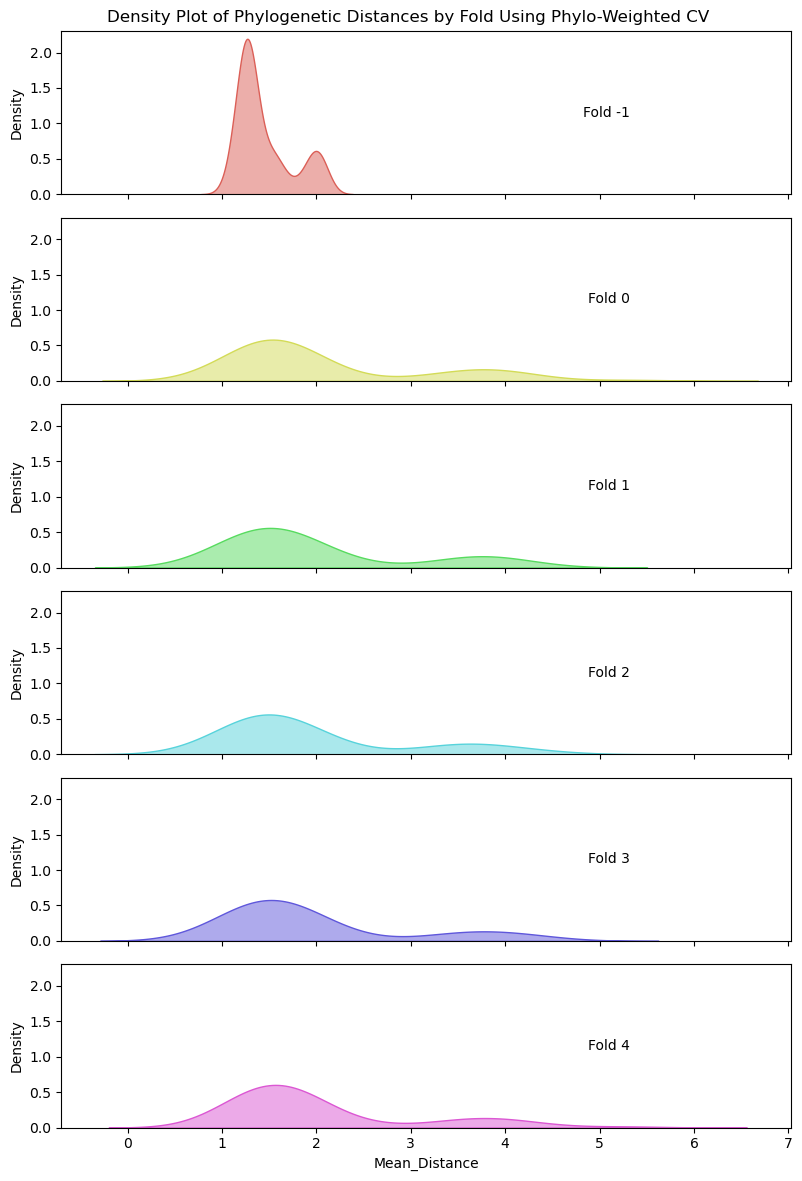

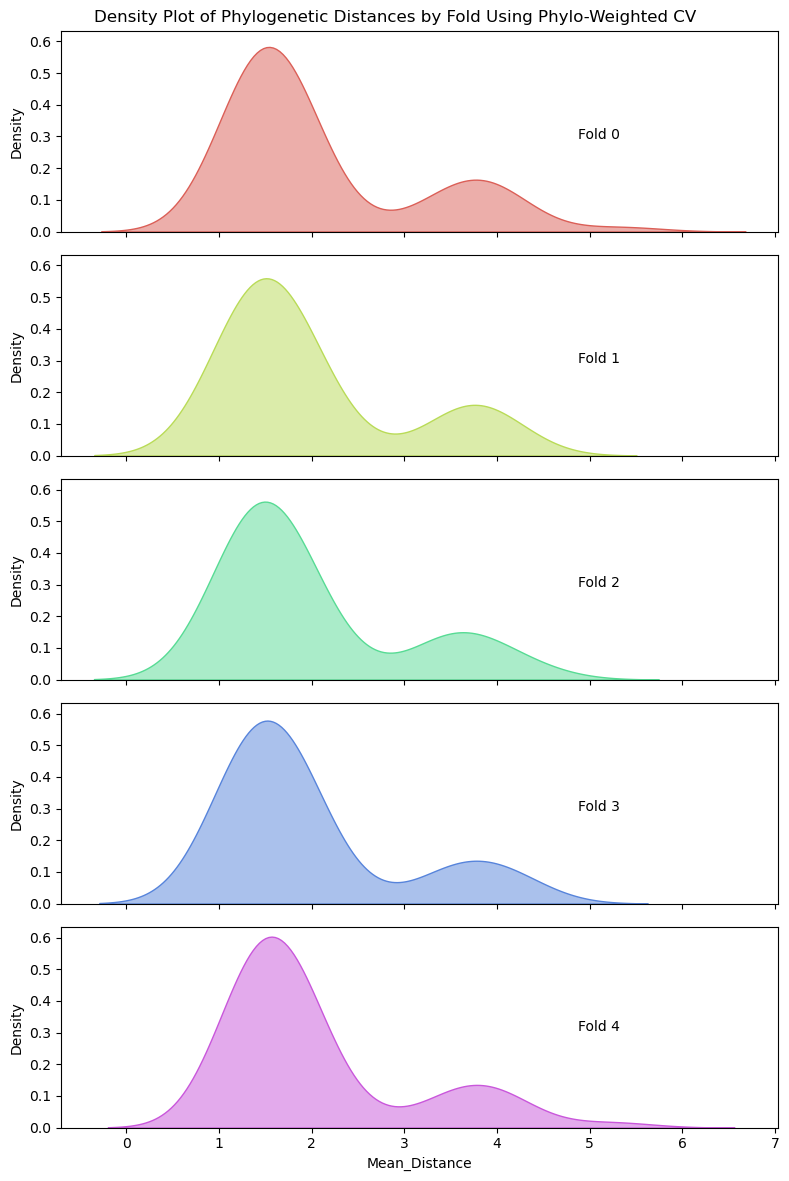

In [6]:
plt_fold_phylo_distributions(tip_to_fold=tip_to_fold, handeling_method=handeling_method, threshold=percentile, n_folds=n_folds, model=model)

In [7]:
unique_classes, class_counts = np.unique(tip_to_fold['Fold'].tolist(), return_counts=True)
print(class_counts)

[156  63  29  28  31  57]


In [8]:
indices = tip_to_fold.index  # Get indices from the DataFrame

In [9]:
from sklearn.model_selection import KFold

# Define cross-validation strategy
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create a new column for fold assignments
tip_to_fold['K-Fold'] = -1  # Initialize with -1 (unassigned)

# Assign fold labels
for fold_num, (train_indices, test_indices) in enumerate(kf.split(indices)):
    #print(f'These are the test indices for fold {fold_num}:\n{test_indices}')
    tip_to_fold['K-Fold'][test_indices.tolist()] = fold_num


C:\Users\safra\AppData\Local\Temp\ipykernel_8252\4190199093.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tip_to_fold['K-Fold'][test_indices.tolist()] = fold_num
C:\Users\safra\AppData\Local\Temp\ipykernel_8252\4190199093.py:12: Setti

In [10]:
kfold_list = tip_to_fold['K-Fold'].tolist()

In [11]:
unique_classes, class_counts = np.unique(kfold_list, return_counts=True)
print(class_counts)

[73 73 73 73 72]


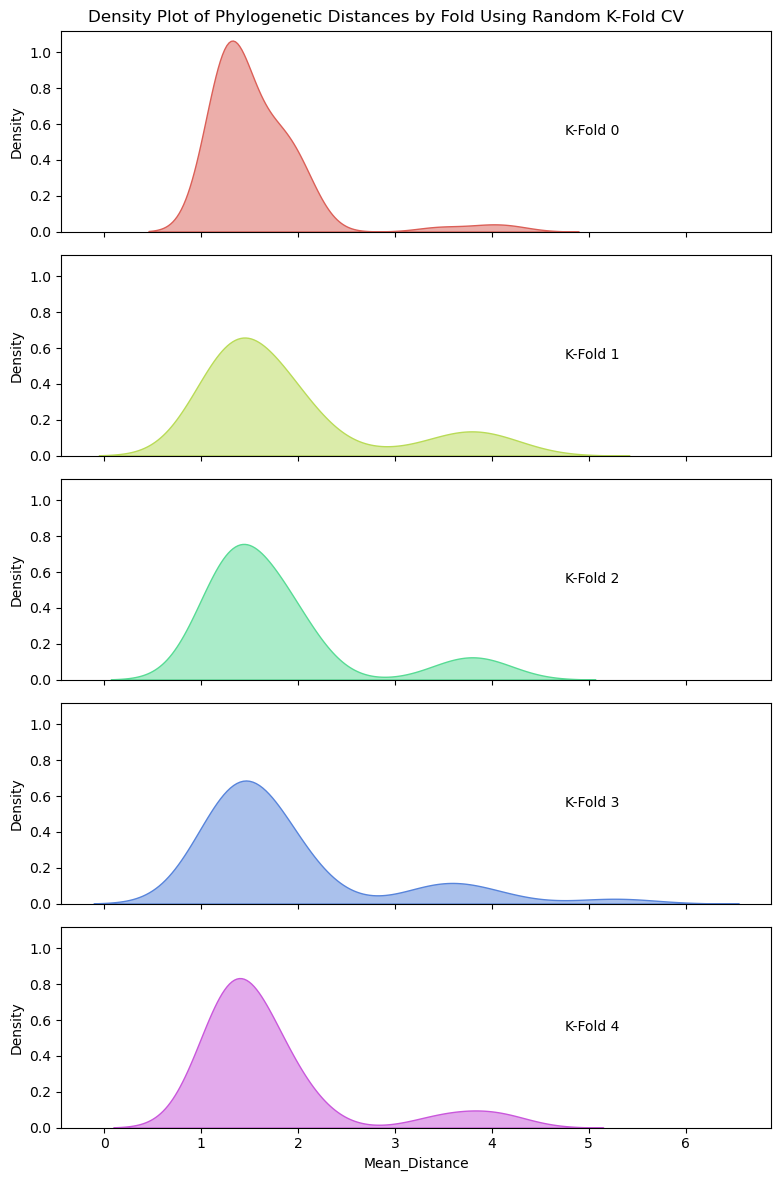

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of unique labels for subplot layout
num_labels = tip_to_fold['K-Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
fig.suptitle('Density Plot of Phylogenetic Distances by Fold Using Random K-Fold CV')

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tip_to_fold['K-Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tip_to_fold['Mean_Distance'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tip_to_fold[tip_to_fold['K-Fold'] == label]['Mean_Distance']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'K-Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.savefig(f'./{model}_random_kfcv_{n_folds}folds_phylo_distributions.svg', format='svg')  # You can change the filename if needed

plt.show()

In [13]:
from deepBreaks.preprocessing import read_data
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [14]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
path = './vpod_1.2_data_splits_2025-02-28_15-51-04'
# path to sequences of interest
seqFileName = f'{path}/wt_aligned_VPOD_1.2_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/wt_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.50

print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape

reading meta-data
reading fasta file


(364, 354)

In [15]:
tr.head(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p345,p346,p347,p348,p349,p350,p351,p352,p353,Lambda_Max
Bovine,M,N,G,T,E,G,P,N,F,Y,...,NaN,NaN,T,S,Q,V,A,P,A,500.0
S1,M,N,G,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,502.0
S2,NaN,NaN,NaN,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,502.0
S3,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,481.0
S4,NaN,NaN,NaN,T,E,G,P,F,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,494.0
S5,NaN,NaN,NaN,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,494.0
S6,M,N,G,T,E,G,P,F,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,491.0
S7,NaN,NaN,NaN,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,486.0
S8,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,490.0
S9,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,490.0


In [16]:
tr = tr.reindex(tip_to_fold.index)

In [17]:
tr.head(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p345,p346,p347,p348,p349,p350,p351,p352,p353,Lambda_Max
Tip_Names,,,,,,,,,,,,,,,,,,,,,
Bovine,M,N,G,T,E,G,P,N,F,Y,...,NaN,NaN,T,S,Q,V,A,P,A,500.0
S1,M,N,G,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,502.0
S2,NaN,NaN,NaN,T,E,G,P,Y,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,502.0
S3,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,481.0
S8,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,490.0
S9,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,A,NaN,NaN,S,S,V,S,P,A,490.0
S325,M,N,G,T,E,G,A,D,F,Y,...,NaN,NaN,NaN,S,S,V,S,P,A,449.0
S326,M,N,G,T,E,G,P,D,F,Y,...,NaN,NaN,S,S,S,V,S,P,A,448.0
S328,M,N,G,T,E,G,P,D,F,Y,...,NaN,NaN,S,S,S,V,S,P,A,455.0


In [18]:
tr['Fold'] = tip_to_fold['Fold']

In [19]:
tr['K-Fold'] = tip_to_fold['K-Fold']

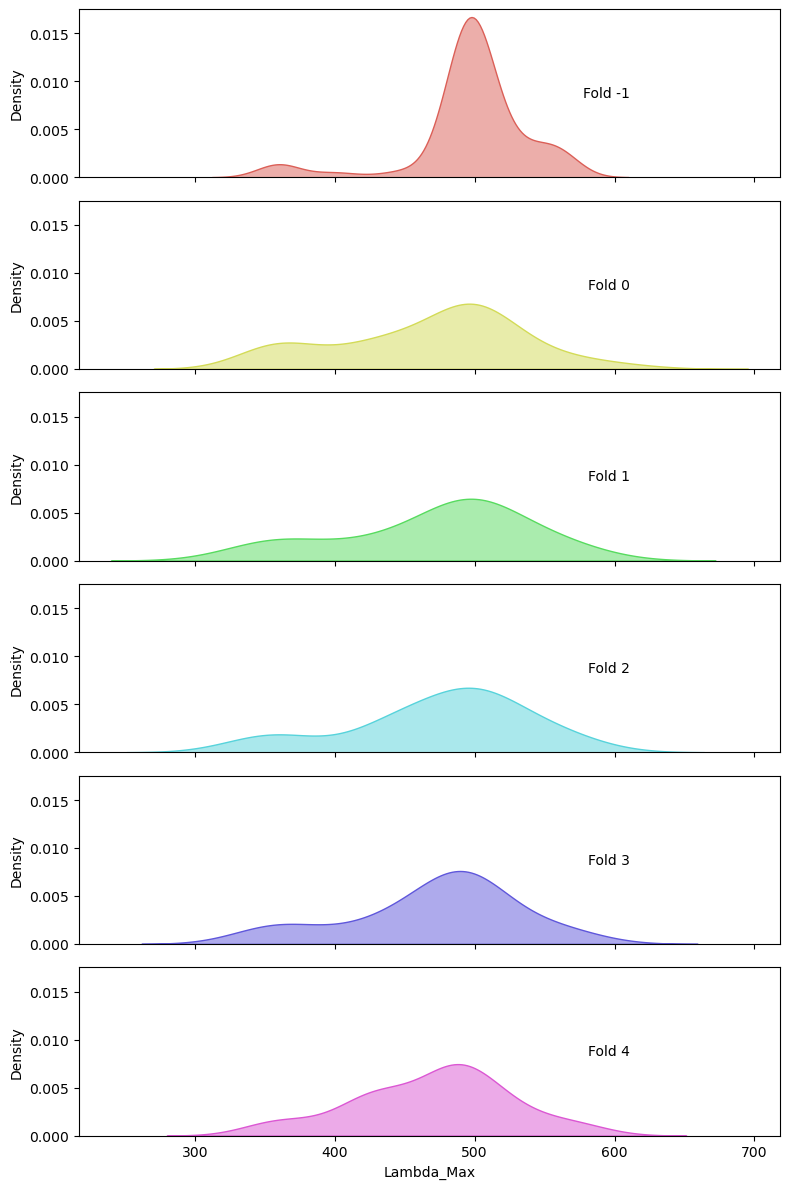

In [20]:
# Determine the number of unique labels for subplot layout
num_labels = tr['Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tr['Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tr['Lambda_Max'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tr[tr['Fold'] == label]['Lambda_Max']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()


plt.savefig(f'./{model}_percentile{percentile}_{handeling_method}_cv_{n_folds}fold_lmax_distributions.svg', format='svg')  # You can change the filename if needed
plt.tight_layout()
plt.show()

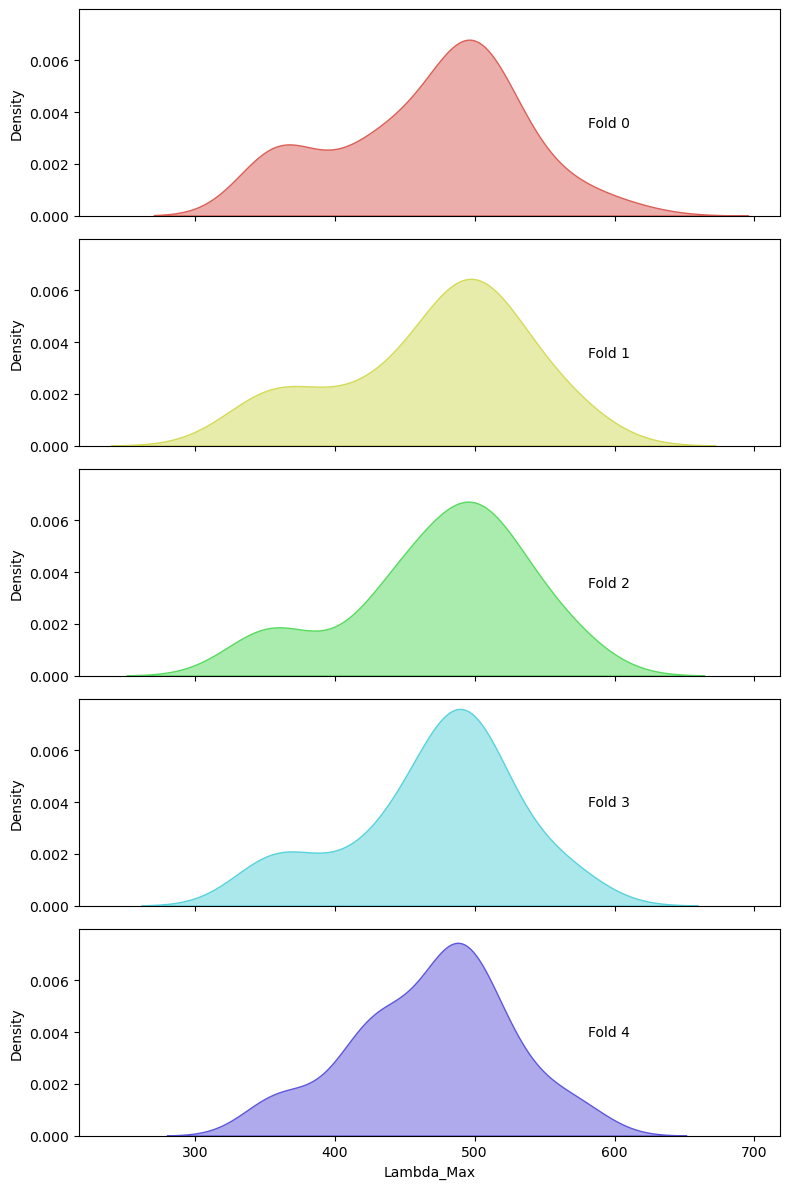

In [21]:
# Determine the number of unique labels for subplot layout
num_labels = tr['Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels-1 / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tr['Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tr['Lambda_Max'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    if label == -1:
        pass
    else:
        ax = axes[i-1]  # Get the current subplot axis
        label_data = tr[tr['Fold'] == label]['Lambda_Max']
        sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i-1], ax=ax)
        # Add label text centered on the x-axis at the mean of Mean_Distance
        ylim = ax.get_ylim()
        ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'Fold {label}',
                horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.savefig(f'./{model}_percentile{percentile}_{handeling_method}_cv_{n_folds}fold_lmax_distributions_noneg.svg', format='svg')  # You can change the filename if needed
plt.show()

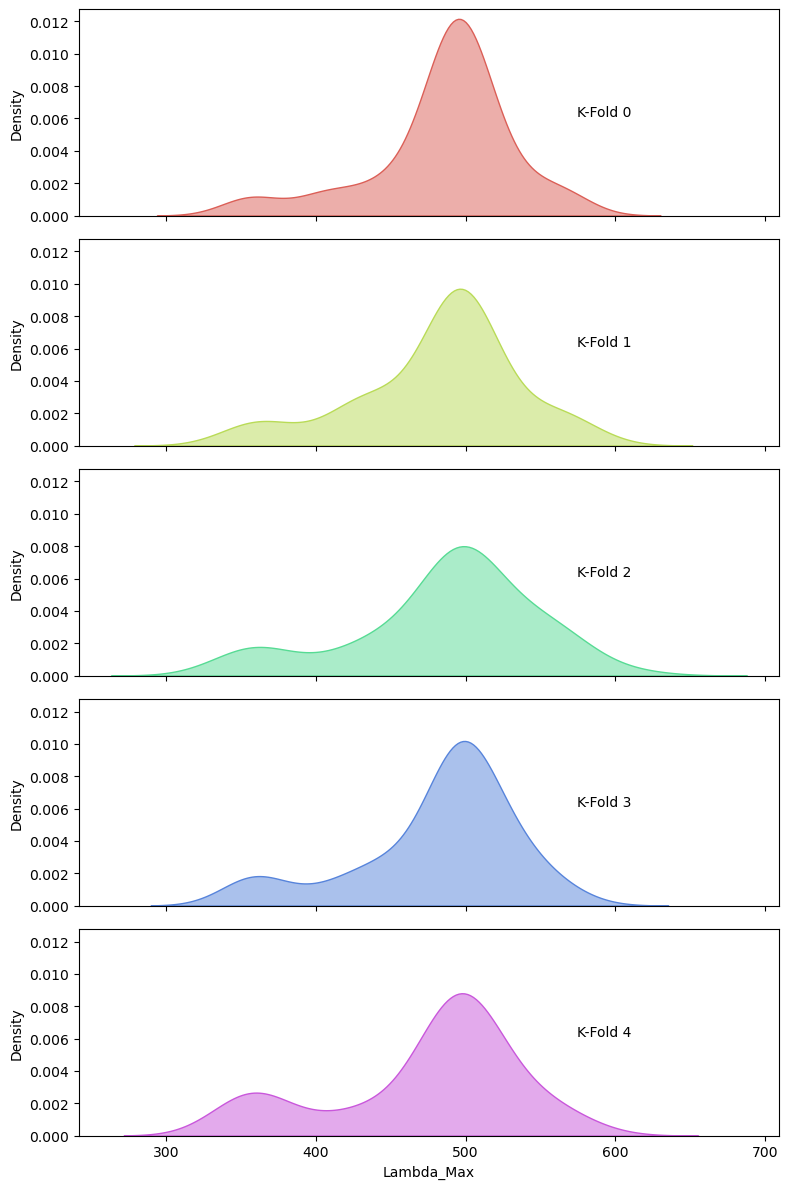

In [22]:
# Determine the number of unique labels for subplot layout
num_labels = tr['K-Fold'].nunique()
num_cols = 1  # You can adjust the number of columns as desired
num_rows = int(np.ceil(num_labels / num_cols))  # Calculate rows based on columns
# Generate Color Palette
colors = sns.color_palette("hls", num_labels)  # Use "hls" or your preferred palette
# Plotting with Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12), sharex=True, sharey=True)  # Create subplot grid
#fig.suptitle('Density Plot of Distances by Label')  # Overall figure title

# Flatten the axes array for easier iteration
axes = axes.flatten()
folds = tr['K-Fold'].unique().tolist()
folds.sort()
# Calculate the mean of the first class
mean_class = tr['Lambda_Max'].max()
# Plot each label's density on a separate subplot
for i, label in enumerate(folds):
    ax = axes[i]  # Get the current subplot axis
    label_data = tr[tr['K-Fold'] == label]['Lambda_Max']
    sns.kdeplot(label_data, fill=True, alpha=0.5,color=colors[i], ax=ax)
    # Add label text centered on the x-axis at the mean of Mean_Distance
    ylim = ax.get_ylim()
    ax.text(mean_class, ylim[0] + (ylim[1] - ylim[0])/2, f'K-Fold {label}',
            horizontalalignment='right', verticalalignment='center')


# Set shared labels only once (for the first subplot in each column and row)
for ax in axes[:]:
    ax.set_ylabel('Density')
    
# Turn off unused subplots
for i in range(num_labels, len(axes)):
    axes[i].set_axis_off()

plt.tight_layout()
plt.savefig(f'./{model}_kfcv_{n_folds}fold_lmax_distributions.svg', format='svg')  # You can change the filename if needed
plt.show()